# MRL Driver Dataset EDA

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from model.common import Anomalies
from model.fonts import set_cmu_serif_font

In [25]:
plt.style.use('seaborn-v0_8-whitegrid')
font = set_cmu_serif_font()
plt.rcParams.update({'font.size': 22})

In [17]:
DRIVER_MAP = {
    'geordi': '2021_08_31_geordi_enyaq',
    'poli': '2021_09_06_poli_enyaq',
    'michal': '2021_11_05_michal_enyaq',
    'dans': '2021_11_18_dans_enyaq',
    'jakub': '2021_11_18_jakubh_enyaq',
}
DRIVER_ID_MAP = {
    'geordi': 'A',
    'poli': 'B',
    'michal': 'C',
    'dans': 'D',
    'jakub': 'E',
}

DATASET_DIR = Path().cwd().parent.parent / 'annotations'
assert DATASET_DIR.exists()

OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

## Ground Truth

This section uses annotation files that were updated to share common names for the same classes. These annotations were not used when evaluating the models to ensure consistency with previous publications.

In [ ]:
def get_anomalies(driver: str) -> Anomalies:
    anomalies_file = DATASET_DIR / f'{DRIVER_MAP[driver]}.txt'
    assert anomalies_file.exists(), f'Anomalies file does not exist: {anomalies_file}'
    anomalies = Anomalies.from_file(anomalies_file, load_video_lengths=False)
    return anomalies

In [32]:
# Extract data

all_anomalies = {driver: get_anomalies(driver) for driver in DRIVER_MAP}

label_counts = Counter()
durations = defaultdict(list)

for anomalies in all_anomalies.values():
    for anomaly in anomalies:
        duration = anomaly.end - anomaly.start
        for label in anomaly.labels:
            label_counts[label] += 1
            durations[label].append(duration)

# Calculate mean and standard deviation for durations
stats = {
    label: (np.mean(durations[label]), np.std(durations[label])) for label in durations
}

In [13]:
custom_order = [
    'only right',
    'only left',
    'hands off',
    'cough',
    'yawn',
    'sneezing',
    'scratch',
    'phone',
    'radio',
    'eyes closed',
    'not looking road',
    'safety belts',
]
assert set(label_counts.keys()) == set(custom_order)

In [14]:
label_renames = {
    'only left': 'only left hand',
    'only right': 'only right hand',
}

In [15]:
counts = [label_counts.get(label, 0) for label in custom_order]
means = [stats[label][0] if label in stats else 0 for label in custom_order]
stds = [stats[label][1] if label in stats else 0 for label in custom_order]
labels = [label_renames.get(label, label) for label in custom_order]

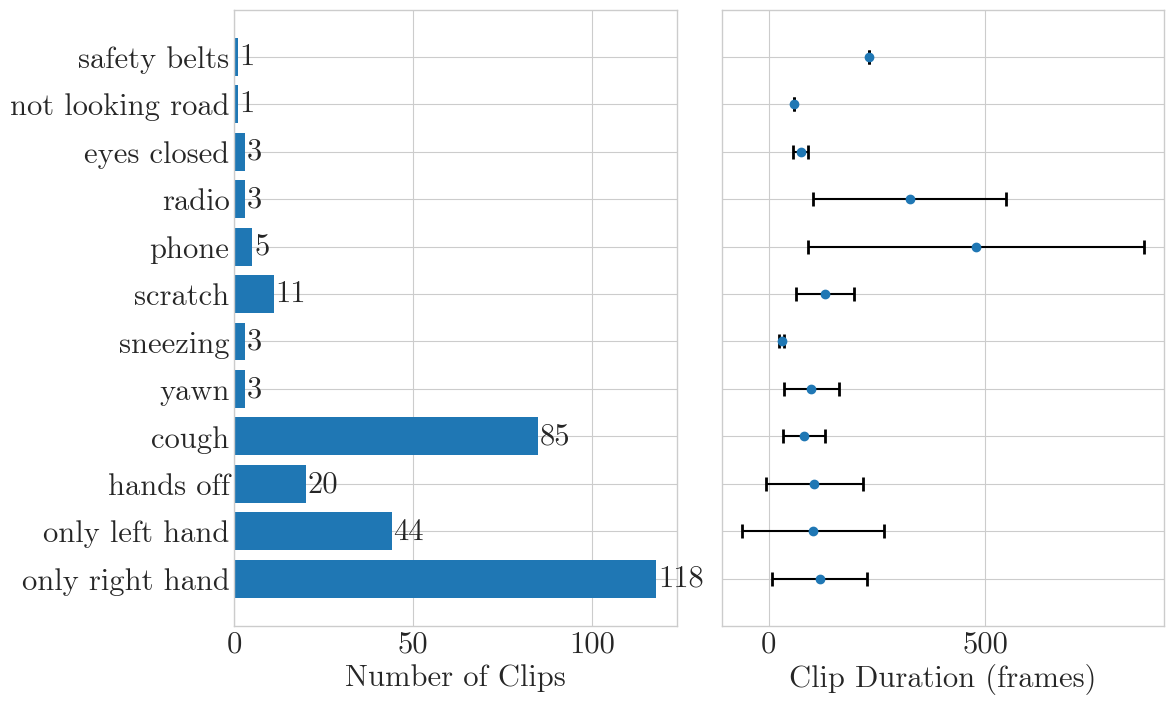

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'wspace': 0.1}
)

# Left plot: Bar plot
axes[0].barh(labels, counts)
axes[0].set_xlabel('Number of Clips')
for i, count in enumerate(counts):
    axes[0].text(count + 0.5, i, f'{count}', va='center')

# Right plot: Error bar plot
axes[1].errorbar(
    means,
    labels,
    xerr=stds,
    fmt='o',
    ecolor='black',
    capsize=5,
    capthick=2,
)
axes[1].set_xlabel('Clip Duration (frames)')

# Remove y-axis labels from the right plot
axes[1].tick_params(labelleft=False)

# plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'anomaly_stats.pdf', bbox_inches='tight')
plt.show()

## Intel RealSense L515

In [27]:
import copy
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from model.common import convert_depth_images_to_video, preprocess_515_cv

In [28]:
source = (
    Path.home()
    / 'source/driver-dataset/2024-10-28-driver-all-frames/2024_07_02_radovan_enyaq/anomal_181149/depth'
)
convert_depth_images_to_video(source, fps=30, limit=1000)

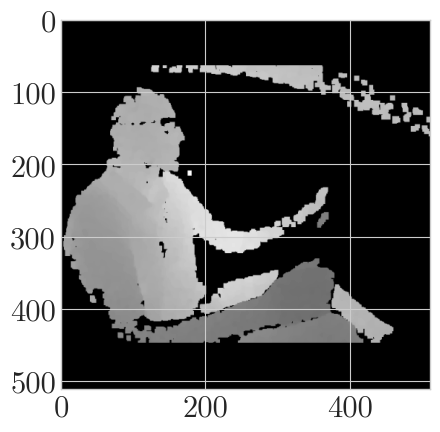

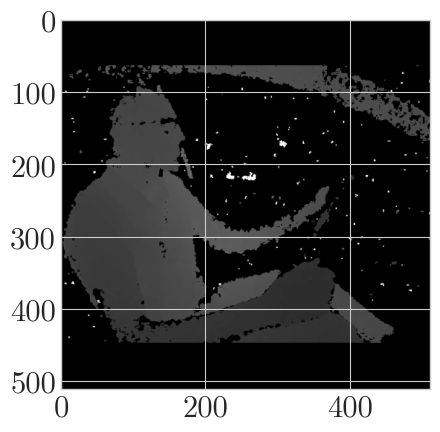

In [29]:
source = (
    Path.home()
    / 'source/driver-dataset/2024-10-28-driver-all-frames/2024_07_02_radovan_enyaq/normal/depth_realsense'
)

img = cv.imread(str(source / 's0_depth_0100.png'), cv.IMREAD_UNCHANGED)
img = np.array(img, dtype=np.uint16)
img = (img / np.iinfo(np.uint16).max).astype(np.float32)

opening = preprocess_515_cv(copy.deepcopy(img), 7)
opening = cv.resize(opening, (512, 512), interpolation=cv.INTER_AREA)
cv.imwrite('outputs/realsense_515_opening.png', opening * 255)
plt.imshow(opening, cmap='gray')
plt.show()

img_prep = preprocess_515_cv(img)
img_prep = cv.resize(img_prep, (512, 512), interpolation=cv.INTER_AREA)
cv.imwrite('outputs/realsense_515.png', img_prep * 255)
plt.imshow(img_prep, cmap='gray')
plt.show()